# Supervised Machine Learning: Regression

## About the data
The dataset obtained from https://www.kaggle.com/datasets/eslamelsolya/laptop-price-prediction?select=laptop_data.csv, includes various laptop models and their features, such as Ram, Resoluton and the Company. These features can be used to train a model to predict the price of the laptops.

Looking at the data specifically, there are no invalid entries, missing values or duplicates, meaning the data looks clean at first sight. Most of the features are non-numerical, however when you take a closer look a lot of numerical information can be extracted. For example the first entry of 'Memory' is 128GB SSD. This could for example be split into two parts, one containing the integer 128 (Memory Size (in GB)), and the SSD part (Memory Type). Various columns have this such as 'Cpu', 'Gpu', 'weight' and many more. Resolution (e.g. 1400x900), can be converted into pixel count by multiplying the two numbers. After dropping the original columns with no interesting categorical/numerical information we are left with 6 categorical columns with a manageable amount of unique values for one-hot encoding later. For now focussing on the numerical features we can check the distributions. All highly skewed data (skew > 1.0) is log-transformed to make the data more normally distributed and symmetric (we will check later what effect this had). After the relevant log-transformation, the correlations can be inspected. Highly correlated features include 'Inches' and 'log(Weight)' ($\rho = 0.87$), and 'log(Ram (GB))' and 'log(Price)' ($\rho = 0.77$). These make intuitive sense since a bigger computer likely weighs more, and more RAM consequently means more advanced machinery, therefore more expensive.
An example of a set of uncorrelated features is 'log(weight)' and 'log(screen resolution)'. There is no intuitive relation between how much a laptop weighs and its resolution. The last step before training Machine Learning Models is to perform feature engineering to try and capture interactions between potentially related features. An example is 'log(screen resolution)' x 'log(Ram)', which are two desirable features. It is important to leave out 'price' in all of the columns, as this is what we are training on. To in the end compare the performance of all the transformations and additions we will compare a few datasets:

- Untransformed: this includes all numerical extractions, but excludes the log-transformed variables
- Log-transformed: this includes all necessary log-transformed variables
- Feature engineered + originals: this adds the new features to the existing log-transformed dataframe
- Feature engineered: this does not keep any of the original used columns for new engineered features as they are dropped to avoid potential colinearity or redundancy.

Finally, the remaining categorical variables are one-hot encoded, before advancing to ML.



## Objective
The objective of this project is to predict the price (log-transformed) of laptops based on various features, including hardware specifications and product characteristics. Through this analysis, we aim to identify which factors contribute most to price prediction and which model performs best in terms of accuracy.


## Linear Regression Models
A baseline linear regression model is used on the untransformed data. 

| $R^{2}$ for each model | Single fold | Cross validated |
| :--------------------: | :---------: | :-------------: |
| Linear regression      |   0.74      |     0.75            |
| Polynomial Features $(n=2)$ | 0.72       |      -5.85       |

For a train-test split we get a $R^{2}$ of 0.74 and for polynomial features with degree 2 this is 0.72. Using cross-validation we get an $R^{2} = 0.75$ for linear regression and for Polynomial Features (n=2) $R^{2} = -5.85$. The latter differs a lot from the first polynomial feature evalution, which hints at a bug. Then when performing the same experiment for the log-transformed data, we see an improved performance, as seen in the table below:

| $R^{2}$ for each model | Single fold | Cross validated |
| :--------------------: | :---------: | :-------------: |
| Linear regression      |   0.80      |     0.80            |
| Polynomial Features $(n=2)$ | 0.78       |      -6.01       |

The model does significantly better with its log-transformed features (done with originally highly skewed features), but cross validation shows an inexplicable huge difference between the single fold and the cross validated $R^{2}$. In both single-fold cases we see that Linear Regression does better than Polynomial features (n=2), so it is okay to leave this out for now, in search of the best model.

In order to prevent overfitting and potentially improve our predictions, we can use regularization. Ridge and LASSO are introduced here. LASSO will then be used for feature selections, as less important coefficients tend to become zero. Grid searches are used for both to optimize for parameters $\alpha$, and *max_iter*


## Key findings
Performing the optimized and cross validated regression models for discussed variants of the data sets, we obtain the results in the table below:

| Model (Cross-validated $R^2$)| Untransformed| Log-transformed | Feature engineered + originals | Feature engineered |
| :---------------------------: | :-----------: | :-------------: | :----------:| :----------: |
| Linear Regression            | 0.745        |   0.802         |   0.816  |   0.794      |           
| Ridge Regression             | not-tested   |   0.803         |   0.815  |   0.794      |   
| Lasso Regression             | not-tested   |   0.803         |   0.816  |   0.796      | 


Ridge as well as LASSO tend to perform either similar or slightly better than regular linear regression. The best results are obtained for the 'feature engineered + originals' data set. The model that omits the original columns and replaces these solely by the new combined features (called 'feature engineered'), performs worse than log-transformed, but better than untransformed.

Going forward with the best predictions ('Feature engineered + originals'), we try to identify the features that are least and most important to the model. These that are unimportant can be omitted, and we can again perform the regressions and see if the scores improve. The latter was not the case.

From LASSO we identify the most important features:
1. Ram (GB)_log        
2. Memory_x_Ram          
3. Inches_x_Ram          
4. Weight_x_Ram_log         
5. ScreenResolution_x_Ram

Ram being the most important one. The 4 following most important features are all dependent on Ram.
The features with the least predictive power with coefficients (practically) zero are: 
1. Gpu_Manufacturer_ARM    
2. OpSys_macOS       
3. Weight_x_Cpu_log    

Omitting these with a certain minimal coefficient threshold and performing regression again, does not improve the model's predictive accuracy, surprisingly.


## Next Steps

The presence of highly correlated features can lead to instability in linear regression models, as seen in cases where engineered features (e.g., 'Memory_x_Ram') had higher importance than original features.
A potential next steop could be to perform Variance Inflation Factor (VIF) analysis to identify and remove features that contribute excessively to multicollinearity. This can help in determining whether to keep both original and engineered features or just one set. After removing near-zero LASSO coefficients, one would expect the model performance to improve, however this did not occur.Instead of blindly removing features, we could explore Recursive Feature Elimination (RFE) to systematically test feature importance.

It is also a good idea to investigate unexpected behavior such as Polynomial features having a high $R^{2}$ value for a single train-test fold, but very low during cross validation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import re

/Users/noahknijff/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Exploratory Data Analysis

### Load the dataset and check it

In [2]:
# Download latest version
path = kagglehub.dataset_download("eslamelsolya/laptop-price-prediction")
dataset_path = "/Users/noahknijff/.cache/kagglehub/datasets/eslamelsolya/laptop-price-prediction/versions/1"
file_name = "laptop_data.csv"  # Update to the correct filename
file_path = os.path.join(dataset_path, file_name)

df = pd.read_csv(file_path)
df_original = df.copy()

display(df.head())


# See column names non-null count and dtype
df.info()

# Count the number of duplicates
num_duplicates = df.duplicated().sum()
print(f"\n Number of duplicate rows: {num_duplicates} \n")

# Count unique values in each object column
unique_counts = df.select_dtypes(include="object").nunique()
print(unique_counts)

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price             1303 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 122.3+ KB

 Number of duplicate rows: 0 

Company              19
TypeName              6
ScreenResolution     40
Cpu                 118
Ram                   9
Memory             

### Extract useful numerical information from non-numerical columns

In [3]:
# Drop unnecessary column
df = df.drop(columns=["Unnamed: 0"])

# Convert Weight column to numeric
df["Weight"] = df["Weight"].str.replace("kg", "").astype(float)
df.rename(columns={"Weight": "Weight_kg"}, inplace=True)

# Split Memory column
# df[["Memory_Size_GB", "Memory_Type"]] = df["Memory"].str.extract(r"(\d+)GB\s*(.*)")
# df["Memory_Size_GB"] = pd.to_numeric(df["Memory_Size_GB"], errors='coerce')
# df.drop(columns=["Memory"], inplace=True)


def extract_memory_details(memory):
    matches = re.findall(r'(\d+)(GB|TB)\s*(\w+)', memory)
    
    memory_sizes = []
    memory_types = []

    for match in matches:
        size = int(match[0]) * 1024 if match[1] == 'TB' else int(match[0])  # Convert TB to GB
        memory_sizes.append(size)
        memory_types.append(match[2])  # Extract memory type (e.g., 'SSD', 'HDD')

    # Return the sum of memory sizes (in GB) and the first memory type found
    return sum(memory_sizes), memory_types[0] if memory_types else None

# Apply the function to the 'Memory' column and ensure Memory_Type is a single value
df[['Memory_Size_GB', 'Memory_Type']] = df['Memory'].apply(lambda x: pd.Series(extract_memory_details(x) if isinstance(x, str) else (None, None)))
df.drop(columns=["Memory"], inplace=True)


# Convert RAM column to numeric
df["Ram_GB"] = df["Ram"].str.extract(r"(\d+)").astype(float)
df.drop(columns=["Ram"], inplace=True)
df.rename(columns={"Ram_GB": "Ram (GB)"}, inplace=True)

# Ensure all Cpu values are strings before extracting details
df["Cpu"] = df["Cpu"].astype(str)
df[["Cpu_Manufacturer", "Cpu_Details"]] = df["Cpu"].str.extract(r"^(\S+)\s+(.*)")

# Extract CPU model and clock speed
df[["Cpu_Model", "Cpu_Clock_Speed_GHz"]] = df["Cpu_Details"].str.extract(r"([\w-]+(?:\s[\w-]+)*)\s*(\d*\.?\d+)GHz")
df["Cpu_Clock_Speed_GHz"] = pd.to_numeric(df["Cpu_Clock_Speed_GHz"], errors="coerce")
df.drop(columns=["Cpu", "Cpu_Details"], inplace=True)

# Split GPU into manufacturer and model
df[["Gpu_Manufacturer", "Gpu_Model"]] = df["Gpu"].str.extract(r"^(\S+)\s+(.*)")
df.drop(columns=["Gpu"], inplace=True)

# Extracting the resolution and converting it to pixel count
df[["Resolution_Width", "Resolution_Height"]] = df["ScreenResolution"].str.extract(r'(\d+)x(\d+)$')
df["Resolution_Width"] = pd.to_numeric(df["Resolution_Width"], errors='coerce')
df["Resolution_Height"] = pd.to_numeric(df["Resolution_Height"], errors='coerce')
df["ScreenResolution"] = df["Resolution_Width"] * df["Resolution_Height"]
df.drop(columns=["Resolution_Width", "Resolution_Height"], inplace=True)

df.drop(columns=["Cpu_Model", "Gpu_Model"], inplace=True)



# Display cleaned data
display(df.head())

# Count unique values in each object column
unique_counts = df.select_dtypes(include="object").nunique()
print('Remaining categorical variables and their unique values:')
print(unique_counts)

,Company,TypeName,Inches,ScreenResolution,OpSys,Weight_kg,Price,Memory_Size_GB,Memory_Type,Ram (GB),Cpu_Manufacturer,Cpu_Clock_Speed_GHz,Gpu_Manufacturer
0,Apple,Ultrabook,13.3,4096000,macOS,1.37,71378.6832,128,SSD,8.0,Intel,0.3,Intel
1,Apple,Ultrabook,13.3,1296000,macOS,1.34,47895.5232,128,Flash,8.0,Intel,0.8,Intel
2,HP,Notebook,15.6,2073600,No OS,1.86,30636.0000,256,SSD,8.0,Intel,0.5,Intel
3,Apple,Ultrabook,15.4,5184000,macOS,1.83,135195.3360,512,SSD,16.0,Intel,0.7,AMD
4,Apple,Ultrabook,13.3,4096000,macOS,1.37,96095.8080,256,SSD,8.0,Intel,0.1,Intel


Remaining categorical variables and their unique values:
Company             19
TypeName             6
OpSys                9
Memory_Type          4
Cpu_Manufacturer     3
Gpu_Manufacturer     4
dtype: int64


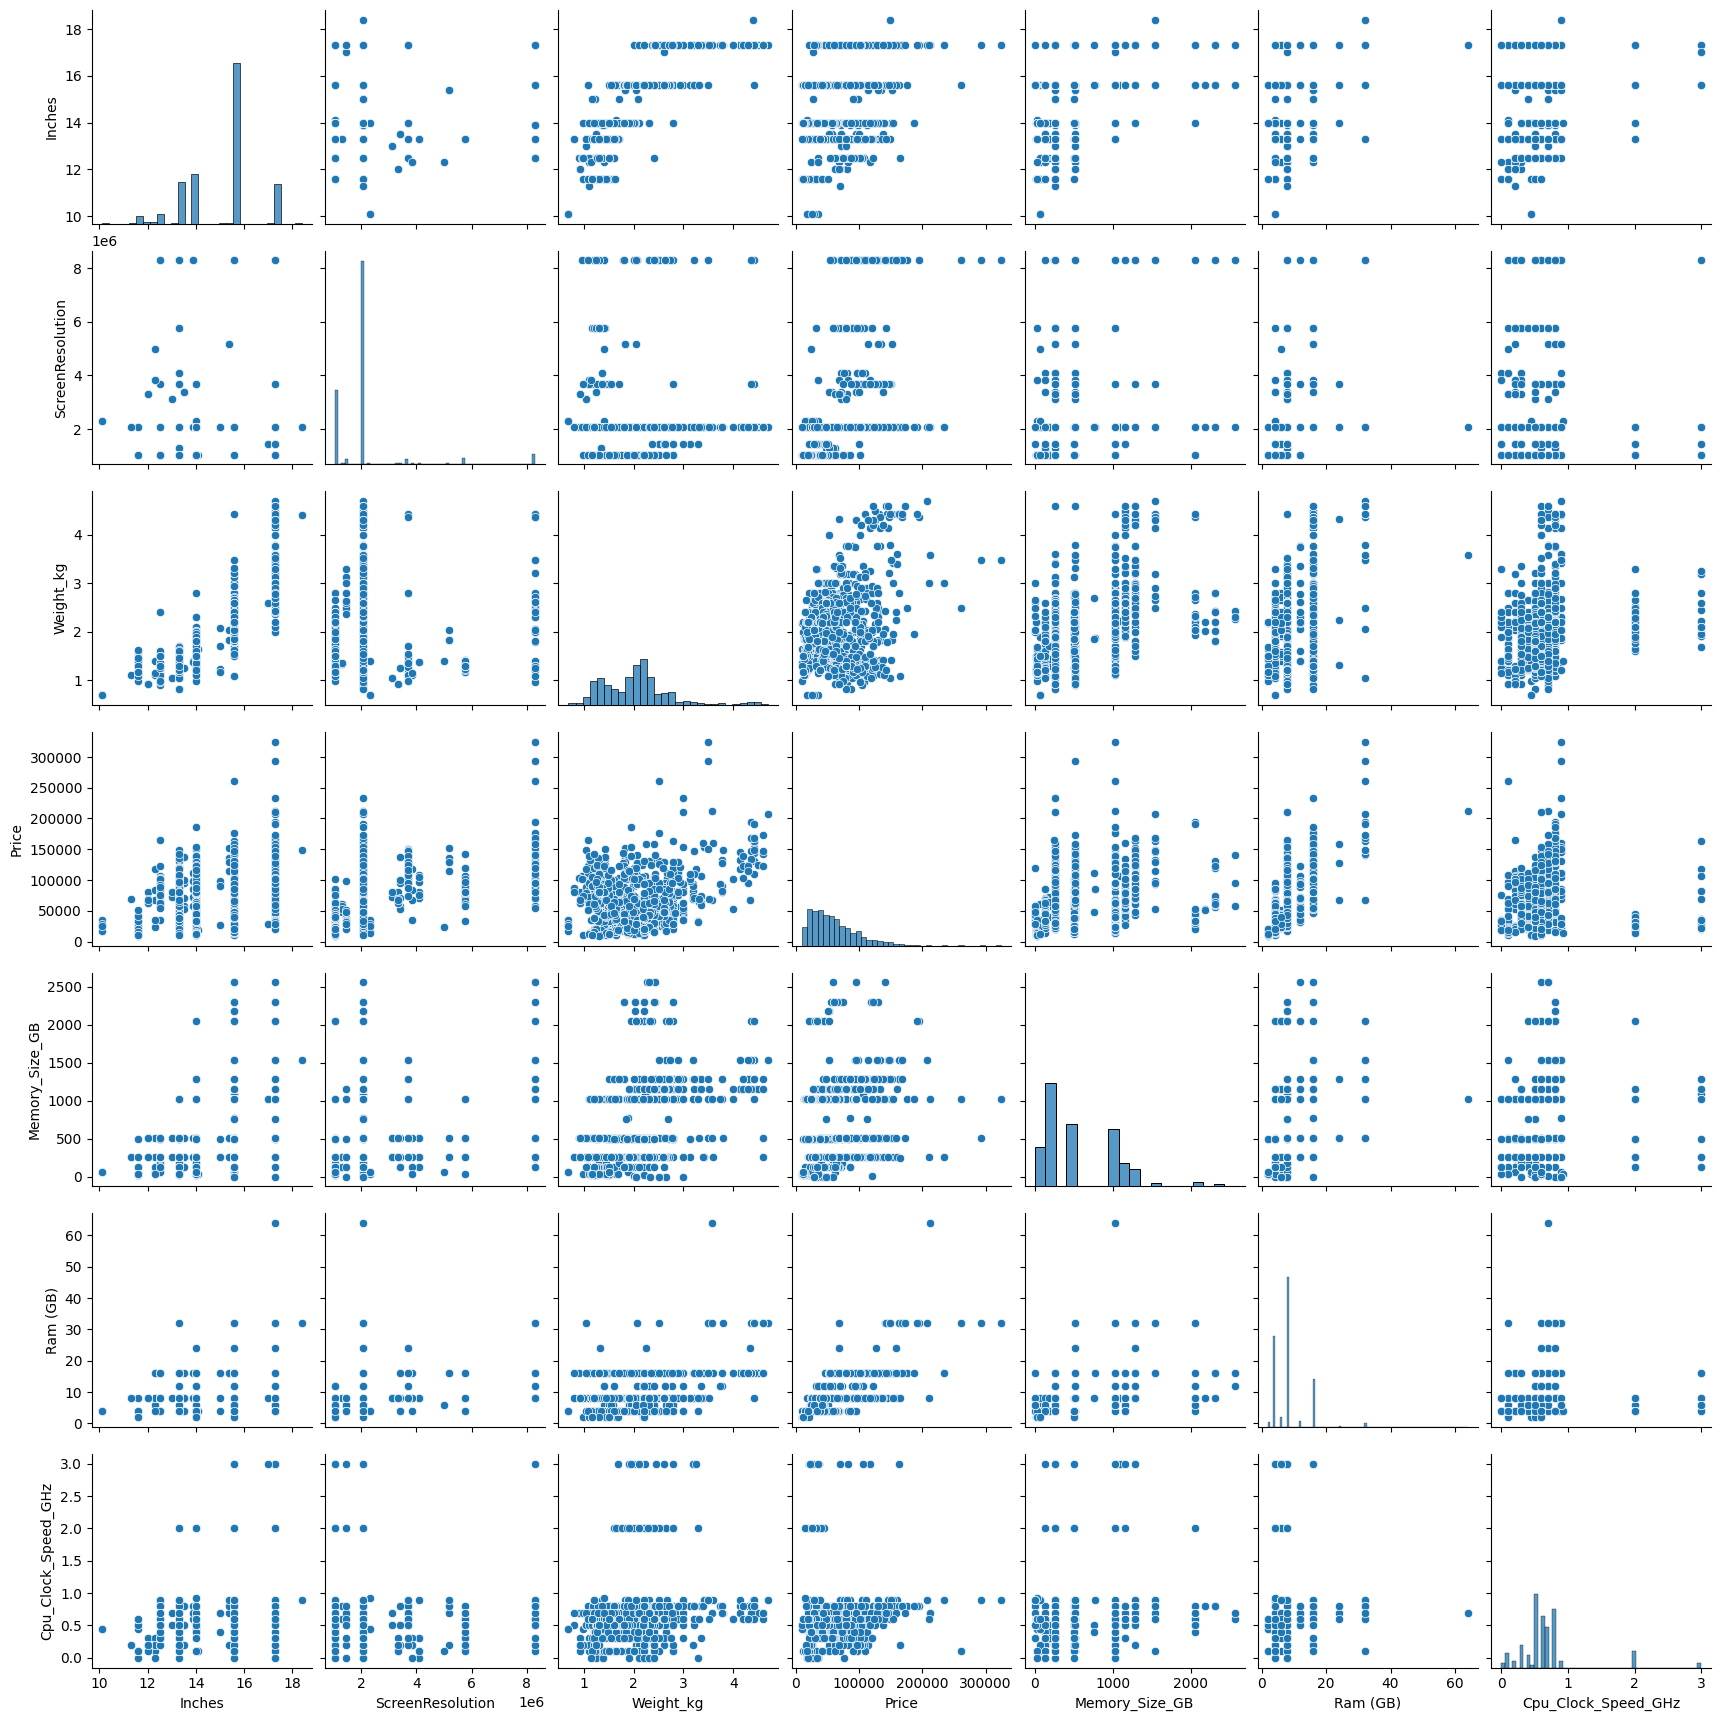

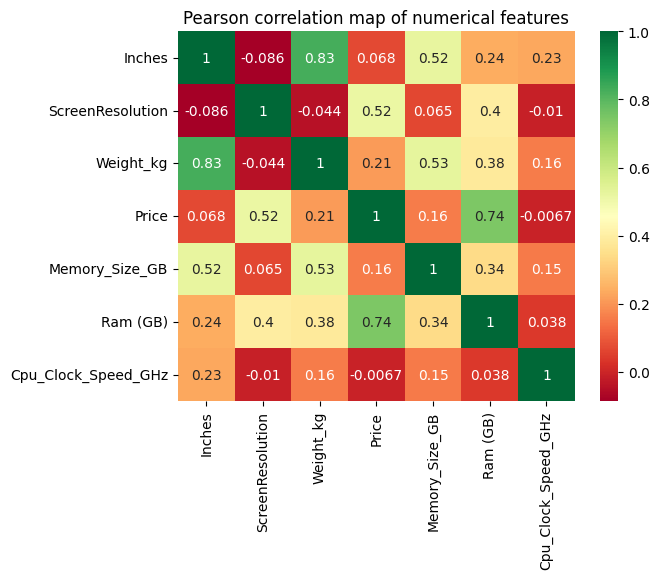

Skew values for numerical features:


ScreenResolution       3.137701
Cpu_Clock_Speed_GHz    2.746870
Ram (GB)               2.686806
Price                  1.520866
Weight_kg              1.144963
Memory_Size_GB         1.075506
Inches                -0.446913
dtype: float64

In [4]:
sns.pairplot(df)
plt.show()

plt.title('Pearson correlation map of numerical features')
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(),annot=True,cmap='RdYlGn')
plt.show()

print("Skew values for numerical features:")
display(df.select_dtypes(include=['float64', 'int64']).skew().sort_values(ascending=False))

### Feature transformation and engineering

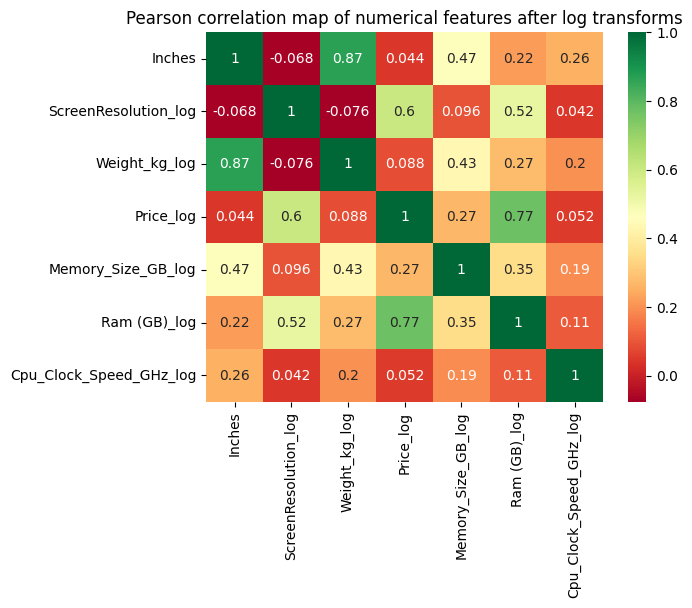

Cpu_Clock_Speed_GHz_log    1.430310
ScreenResolution_log       0.985280
Ram (GB)_log               0.423571
Weight_kg_log              0.327732
Price_log                 -0.174096
Inches                    -0.446913
Memory_Size_GB_log        -1.745976
dtype: float64

After one-hot encoding df has 46 features, and df_engineering has 53 features


In [5]:
# Function to apply log transform to all numerical columns if their skewness is above the threshold
def apply_log_transform_to_skewed_columns(df, skew_threshold=1):
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    
    for column in numerical_columns:
        skewness = df[column].skew()

        # Check if the skewness is above the threshold apply a log transformation
        if skewness > skew_threshold:
            new_column_name = f"{column}_log"
            df[new_column_name] = np.log1p(df[column])  # log(x + 1) to handle 0 values
            df.drop(columns=[column], inplace=True)
            
    return df

df_untransformed = df.copy()
df = apply_log_transform_to_skewed_columns(df, skew_threshold=1)

plt.title('Pearson correlation map of numerical features after log transforms')
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(),annot=True,cmap='RdYlGn')
plt.show()

display(df.select_dtypes(include=['float64', 'int64']).skew().sort_values(ascending=False))


# One-hot encoding for all categorical variables
df = pd.get_dummies(df, drop_first=True)  # drop_first=True to avoid dummy variable trap
df_untransformed = pd.get_dummies(df_untransformed, drop_first=True) 


df_engineering = df.copy()

# Add new engineered features
df_engineering["Inches_x_Ram"] = df["Inches"] * df["Ram (GB)_log"]  # Interaction between inches and ram
df_engineering["Weight_x_Ram"] = df["Weight_kg_log"] * df["Ram (GB)_log"]  # Interaction between weight and ram
df_engineering["ScreenResolution_x_Ram"] = df["ScreenResolution_log"] * df["Ram (GB)_log"]  # Interaction between screen resolution and ram
df_engineering["Cpu_Speed_x_Ram"] = df["Cpu_Clock_Speed_GHz_log"] * df["Ram (GB)_log"]  # Interaction between cpu speed and ram
df_engineering["Memory_x_Ram"] = df["Memory_Size_GB_log"] * df["Ram (GB)_log"]  # Interaction between memory size and ram
df_engineering["Weight_x_Cpu"] = df["Weight_kg_log"] * df["Cpu_Clock_Speed_GHz_log"]  # Interaction between weight and cpu speed
df_engineering["Inches_x_Cpu"] = df["Inches"] * df["Cpu_Clock_Speed_GHz_log"]  # Interaction between inches and cpu speed

# Drop some original features to avoid multi-colinearity and redundancy
# df_engineering.drop(columns=["Inches"], inplace=True)
# df_engineering.drop(columns=["Ram (GB)_log"], inplace=True)
# df_engineering.drop(columns=["Weight_kg_log"], inplace=True)
# df_engineering.drop(columns=["ScreenResolution_log"], inplace=True)
# df_engineering.drop(columns=["Cpu_Clock_Speed_GHz_log"], inplace=True)
# df_engineering.drop(columns=["Memory_Size_GB_log"], inplace=True)




# Make new features more symmetric
df_engineering = apply_log_transform_to_skewed_columns(df_engineering, skew_threshold=1)

print(f"After one-hot encoding df has {len(list(df.columns))} features, and df_engineering has {len(list(df_engineering.columns))} features")


## 2. Regression

### Linear regression

In [6]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline


def regression(df):
    
    # Separate features and target based on available column
    if 'Price_log' in df.columns:
        X = df.drop(columns=['Price_log'])
        y = df['Price_log']
    else:
        # If 'Price_log' is not available, fall back to 'Price'
        X = df.drop(columns=['Price'])
        y = df['Price']

    # Scaling features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Vanilla Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    print('For a single train-test split:')
    print(f"Linear Regression - R²: {r2_score(y_test, y_pred)}")

    # Polynomial Regression
    poly_pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_pipeline.fit(X_train, y_train)
    y_pred_poly = poly_pipeline.predict(X_test)
    print(f"Polynomial Regression - R²: {r2_score(y_test, y_pred_poly)}")

    # Cross-validation
    lr_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring="r2").mean()
    pf_r2 = cross_val_score(poly_pipeline, X_train, y_train, cv=5, scoring="r2").mean()

    print("Cross validation:")
    print("Linear Regression R²:", lr_r2)
    print("Polynomial Features (n=2) R²:", pf_r2)
    print('\n')
    

# Now you can call the regression function on both transformed and untransformed data
print('For the untransformed data we get:')
regression(df_untransformed)
print('For the log-transformed data we get:')
regression(df)


For the untransformed data we get:
For a single train-test split:
Linear Regression - R²: 0.7446065480544668
Polynomial Regression - R²: 0.7121053623971224
Cross validation:
Linear Regression R²: 0.7454288479038681
Polynomial Features (n=2) R²: -5.850092869984354


For the log-transformed data we get:
For a single train-test split:
Linear Regression - R²: 0.8033254958158433
Polynomial Regression - R²: 0.7853506014741429
Cross validation:
Linear Regression R²: 0.802160099318996
Polynomial Features (n=2) R²: -6.013119991300101




Best Ridge alpha: {'alpha': 10}  | R²: 0.8033128321919291
Best Lasso alpha: {'alpha': 0.001}  | R²: 0.8033420539043691
                     Feature  Lasso Coefficient  Abs Coefficient
4               Ram (GB)_log       2.416928e-01     2.416928e-01
39           Memory_Type_SSD       1.609437e-01     1.609437e-01
26         TypeName_Notebook      -1.145734e-01     1.145734e-01
12                Company_HP       9.381461e-02     9.381461e-02
1       ScreenResolution_log       9.131983e-02     9.131983e-02
35           OpSys_Windows 7       8.912156e-02     8.912156e-02
3         Memory_Size_GB_log       6.973483e-02     6.973483e-02
21           Company_Toshiba       6.819615e-02     6.819615e-02
33          OpSys_Windows 10       6.644426e-02     6.644426e-02
9               Company_Dell       6.489789e-02     6.489789e-02
15            Company_Lenovo       6.218049e-02     6.218049e-02
6              Company_Apple       5.772359e-02     5.772359e-02
40    Cpu_Manufacturer_Intel       5

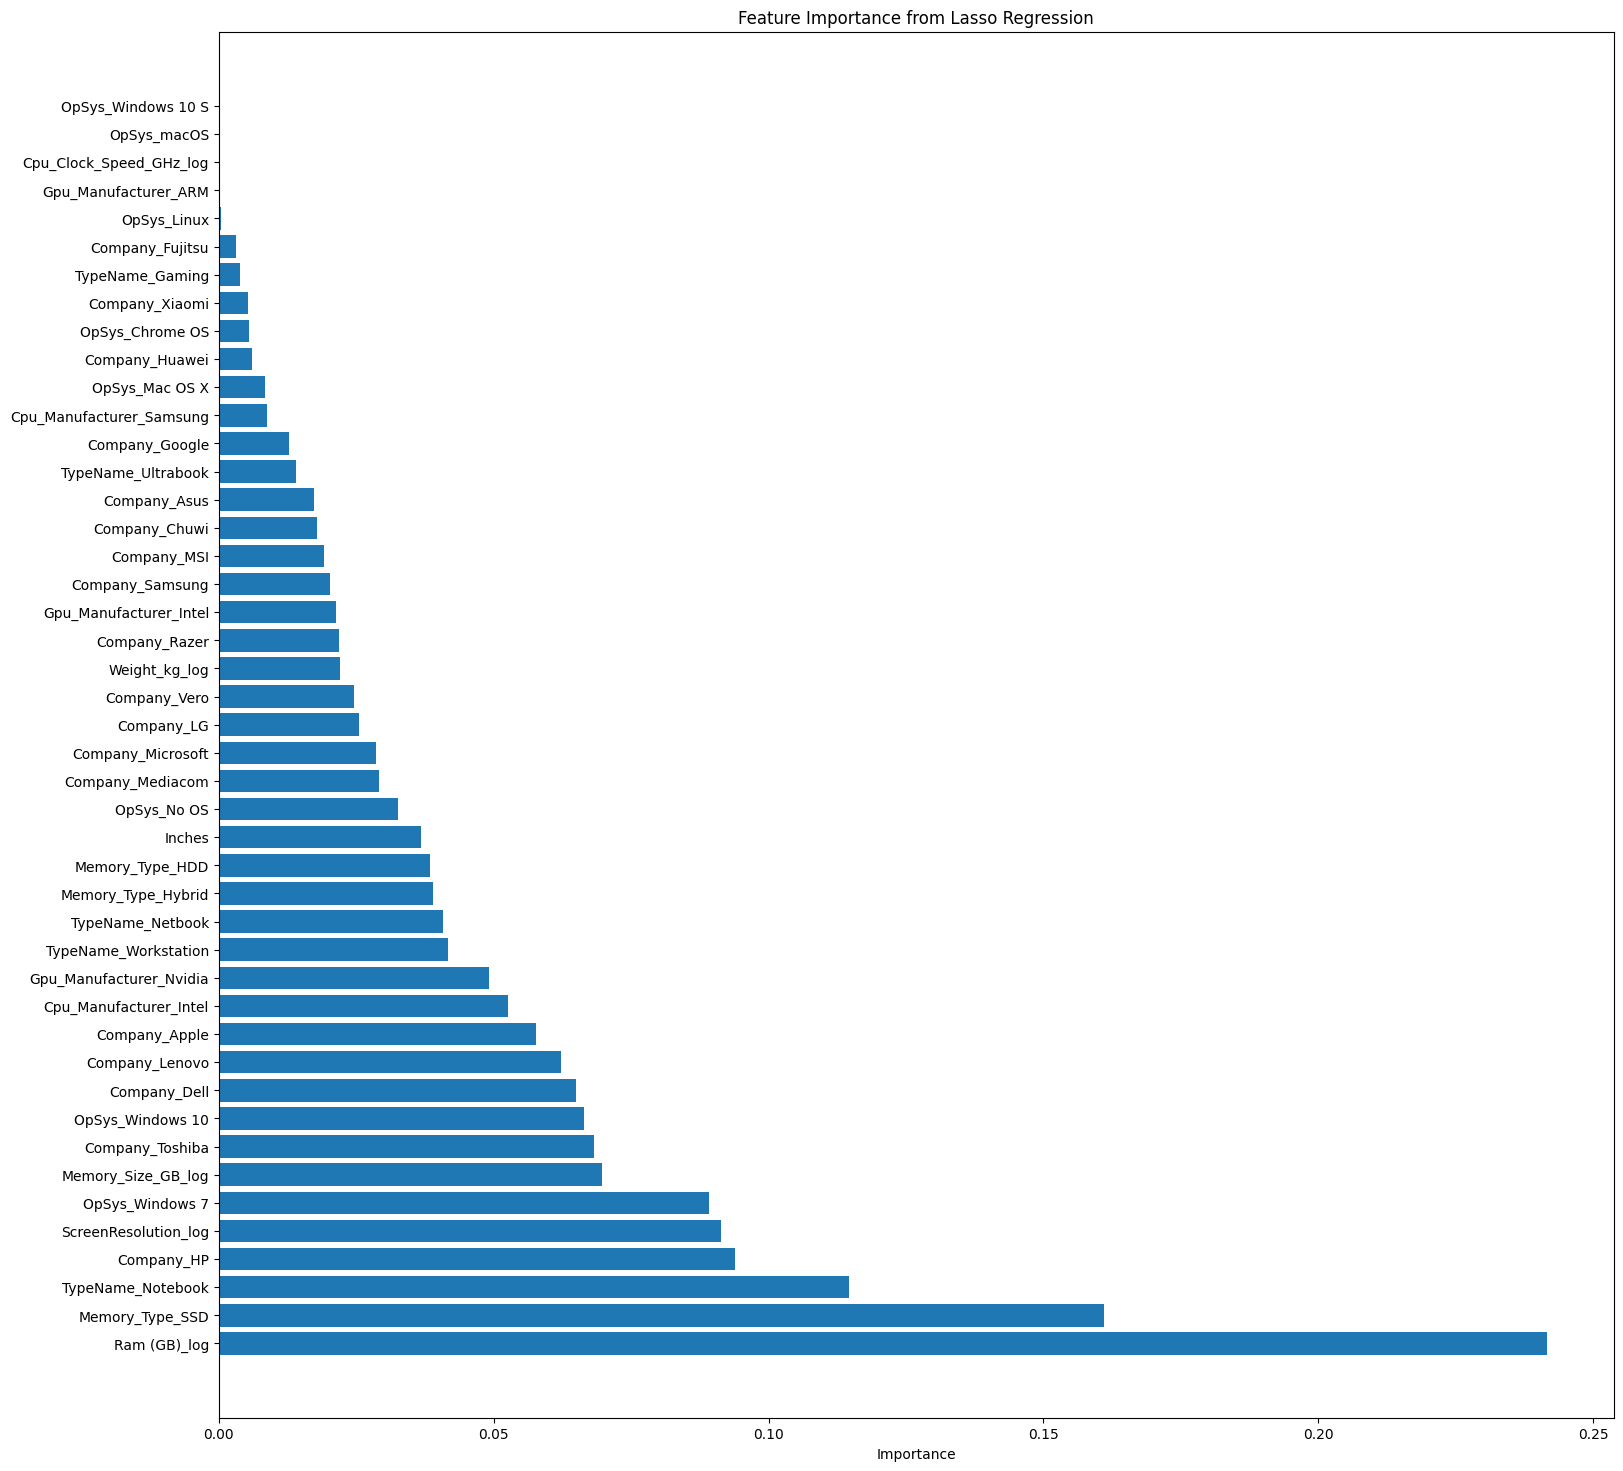

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

X = df.drop(columns=['Price_log'])
y = df['Price_log']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Define parameter grid
alpha_values = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Grid search for Ridge with R² scoring
ridge_grid = GridSearchCV(Ridge(), param_grid=alpha_values, cv=5, scoring="r2")
ridge_grid.fit(X_train, y_train)
best_ridge_r2 = ridge_grid.best_score_
print("Best Ridge alpha:", ridge_grid.best_params_, " | R²:", best_ridge_r2)

# Grid search for Lasso with R² scoring
lasso_grid = GridSearchCV(Lasso(), param_grid=alpha_values, cv=5, scoring="r2")
lasso_grid.fit(X_train, y_train)
best_lasso_r2 = lasso_grid.best_score_
print("Best Lasso alpha:", lasso_grid.best_params_, " | R²:", best_lasso_r2)


# Get Lasso coefficients (importance of each feature) from the best Lasso model
lasso_coefficients = lasso_grid.best_estimator_.coef_

# Create a dataframe to show the features and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Lasso Coefficient': lasso_coefficients
})

# Sort the feature importance by absolute coefficient values to see which are most impactful
feature_importance['Abs Coefficient'] = feature_importance['Lasso Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs Coefficient', ascending=False)

# Display the top features
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(18,18))
plt.barh(feature_importance['Feature'], feature_importance['Abs Coefficient'])
plt.xlabel('Importance')
plt.title('Feature Importance from Lasso Regression')
plt.show()


Cross validated and optimized results:
Linear Regression R²: 0.815562353094411
Best Ridge alpha: {'alpha': 0.1, 'max_iter': 10000}  | R²: 0.8156176952584644
Best Lasso alpha: {'alpha': 0.0001, 'max_iter': 10000}  | R²: 0.8154870029985973
Filtered Feature Importances:
                        Feature  Lasso Coefficient  Abs Coefficient
4                  Ram (GB)_log       1.113761e+00     1.113761e+00
47                 Memory_x_Ram      -8.163959e-01     8.163959e-01
49             Weight_x_Ram_log      -6.721602e-01     6.721602e-01
44                 Inches_x_Ram       6.308985e-01     6.308985e-01
3            Memory_Size_GB_log       5.214089e-01     5.214089e-01
45       ScreenResolution_x_Ram      -5.030329e-01     5.030329e-01
2                 Weight_kg_log       4.130384e-01     4.130384e-01
0                        Inches      -2.939288e-01     2.939288e-01
32             OpSys_Windows 10       2.235516e-01     2.235516e-01
48  Cpu_Clock_Speed_GHz_log_log      -2.179886e-01  

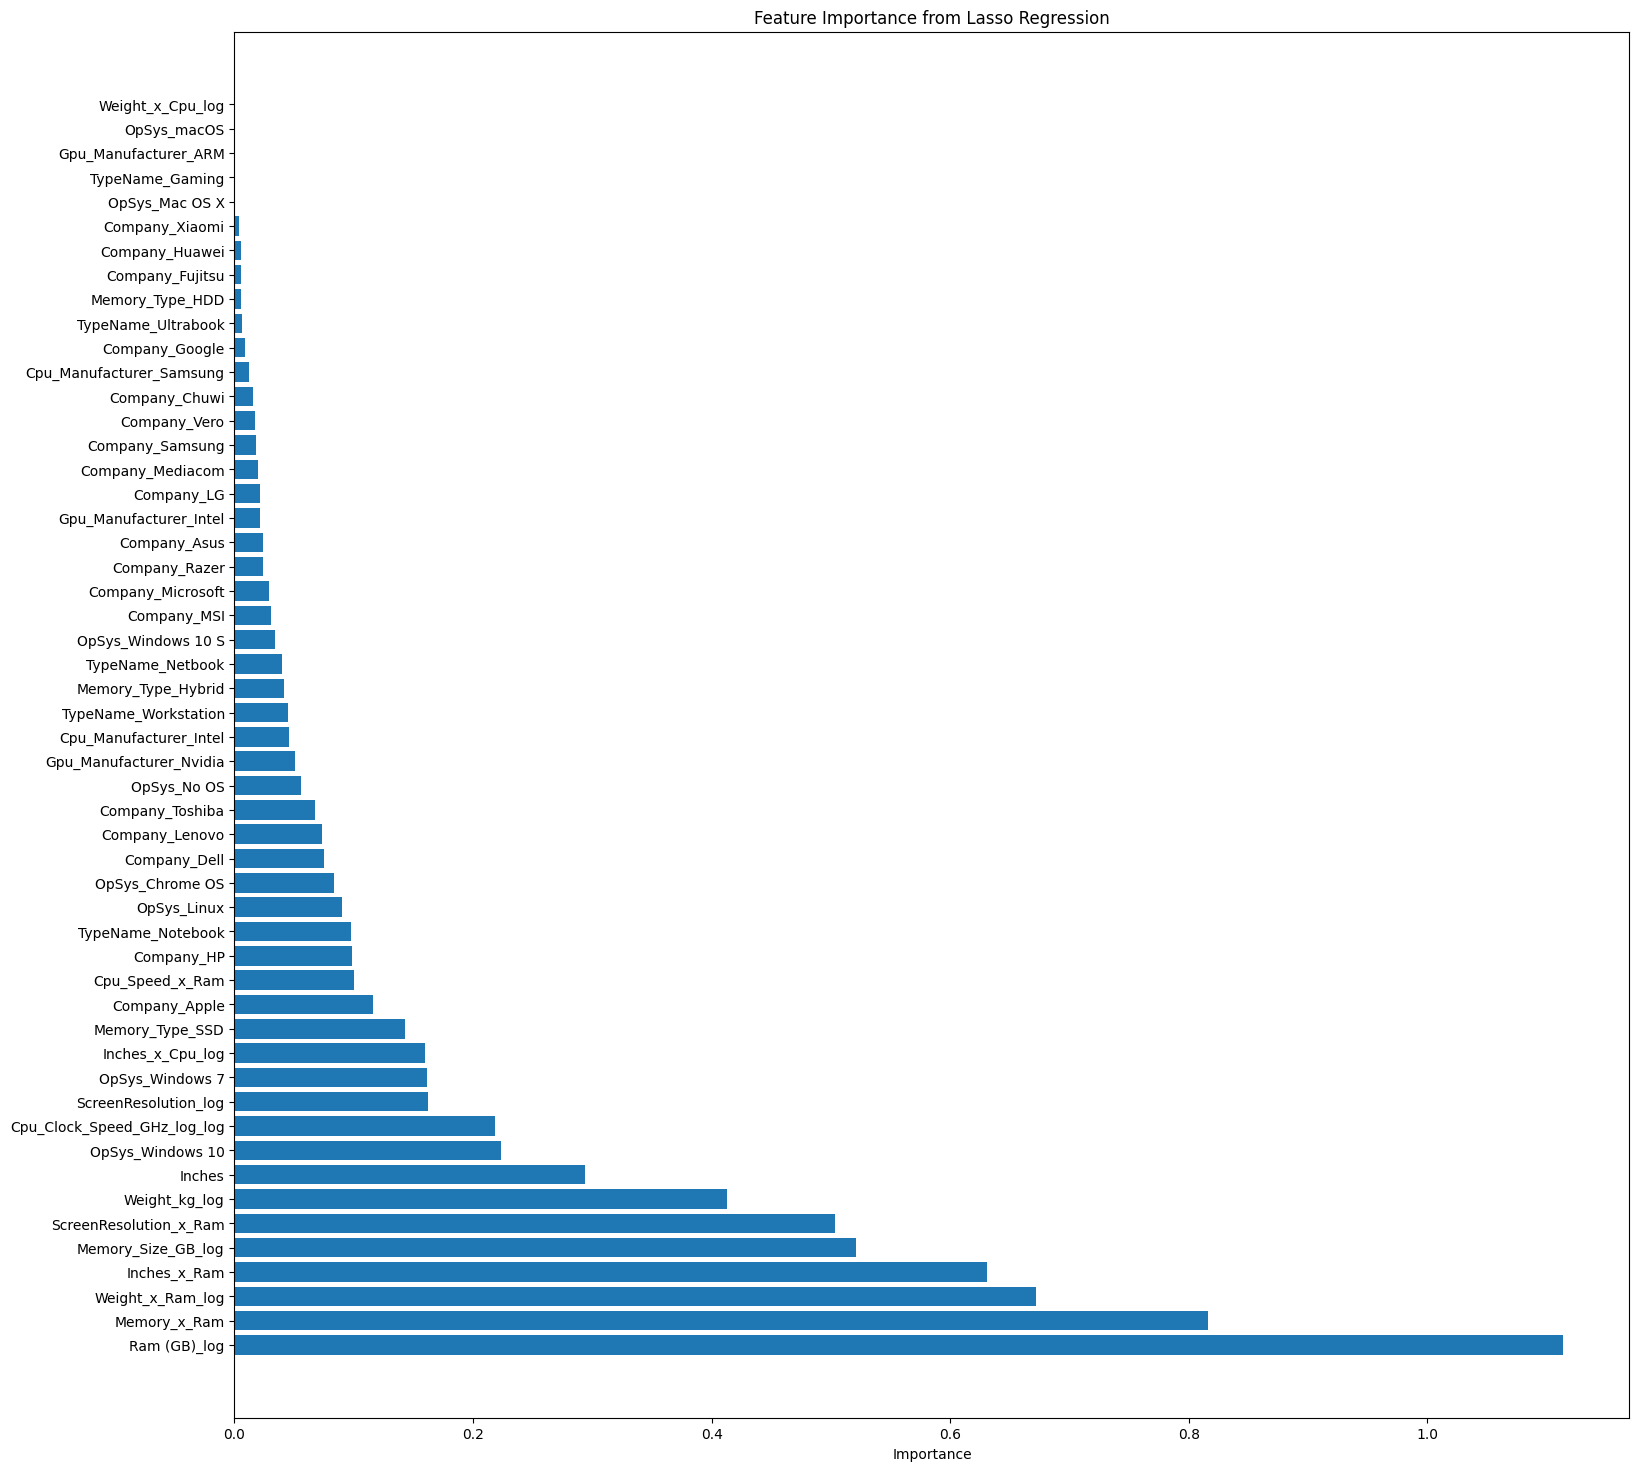

Cross validated and optimized results:
Linear Regression R²: 0.815562353094411
Best Ridge alpha: {'alpha': 0.1, 'max_iter': 10000}  | R²: 0.8156176952584652
Best Lasso alpha: {'alpha': 0.0001, 'max_iter': 10000}  | R²: 0.8154674739749378
Filtered Feature Importances:
                        Feature  Lasso Coefficient  Abs Coefficient
0                  Ram (GB)_log           1.104110         1.104110
1                  Memory_x_Ram          -0.816088         0.816088
2              Weight_x_Ram_log          -0.669768         0.669768
3                  Inches_x_Ram           0.630293         0.630293
4            Memory_Size_GB_log           0.521233         0.521233
5        ScreenResolution_x_Ram          -0.493916         0.493916
6                 Weight_kg_log           0.411655         0.411655
7                        Inches          -0.293733         0.293733
8              OpSys_Windows 10           0.223182         0.223182
9   Cpu_Clock_Speed_GHz_log_log          -0.217986  

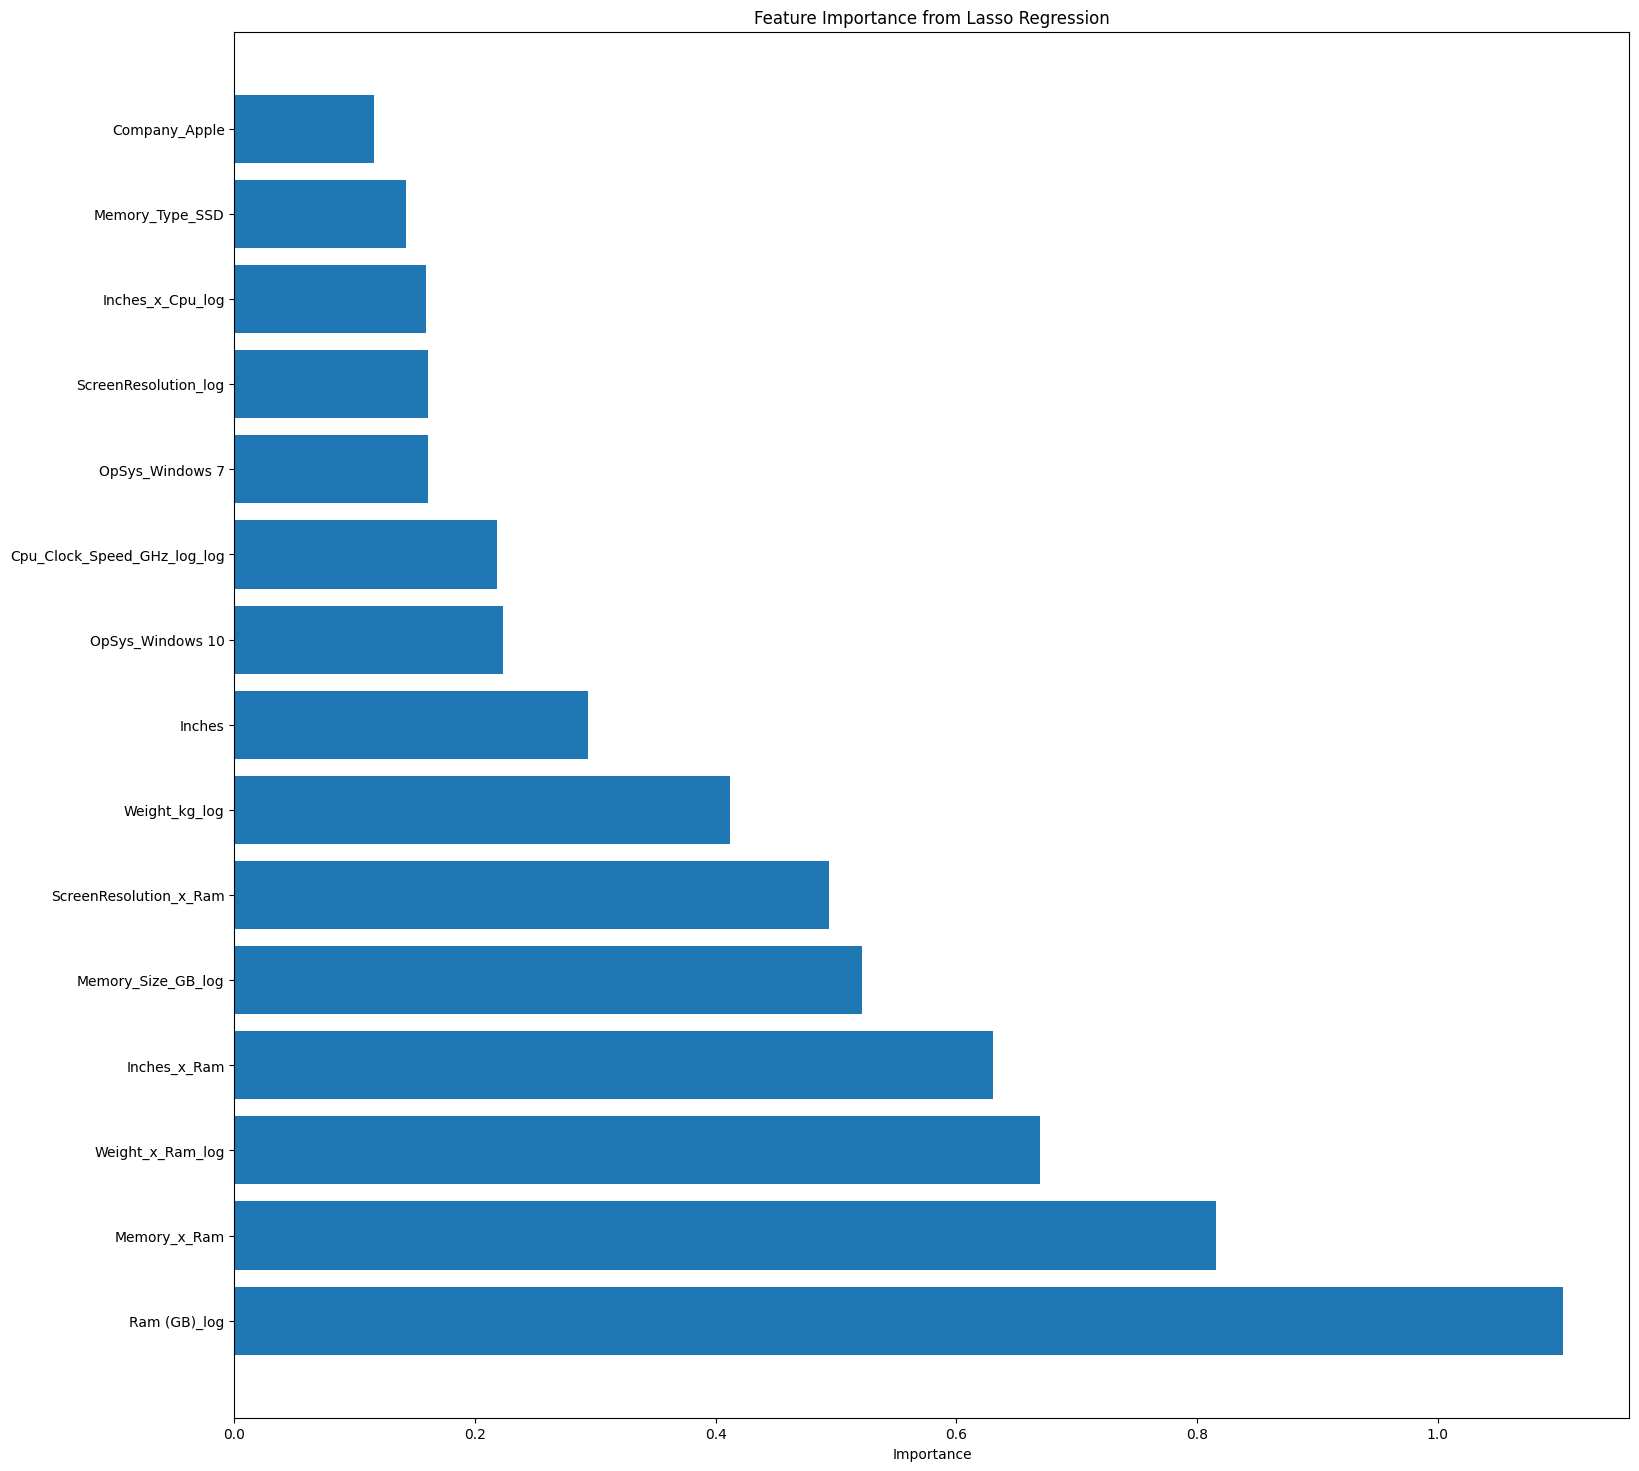

Cross validated and optimized results:
Linear Regression R²: 0.7638914417124478
Best Ridge alpha: {'alpha': 0.01, 'max_iter': 10000}  | R²: 0.7639138127080635
Best Lasso alpha: {'alpha': 0.0001, 'max_iter': 10000}  | R²: 0.763669403610528
Filtered Feature Importances:
                        Feature  Lasso Coefficient  Abs Coefficient
0                  Ram (GB)_log           1.423519         1.423519
1                  Memory_x_Ram          -1.053250         1.053250
3                  Inches_x_Ram           0.850268         0.850268
2              Weight_x_Ram_log          -0.829026         0.829026
5        ScreenResolution_x_Ram          -0.631294         0.631294
4            Memory_Size_GB_log           0.628098         0.628098
6                 Weight_kg_log           0.526064         0.526064
7                        Inches          -0.407196         0.407196
11         ScreenResolution_log           0.205304         0.205304
12             Inches_x_Cpu_log           0.175055 

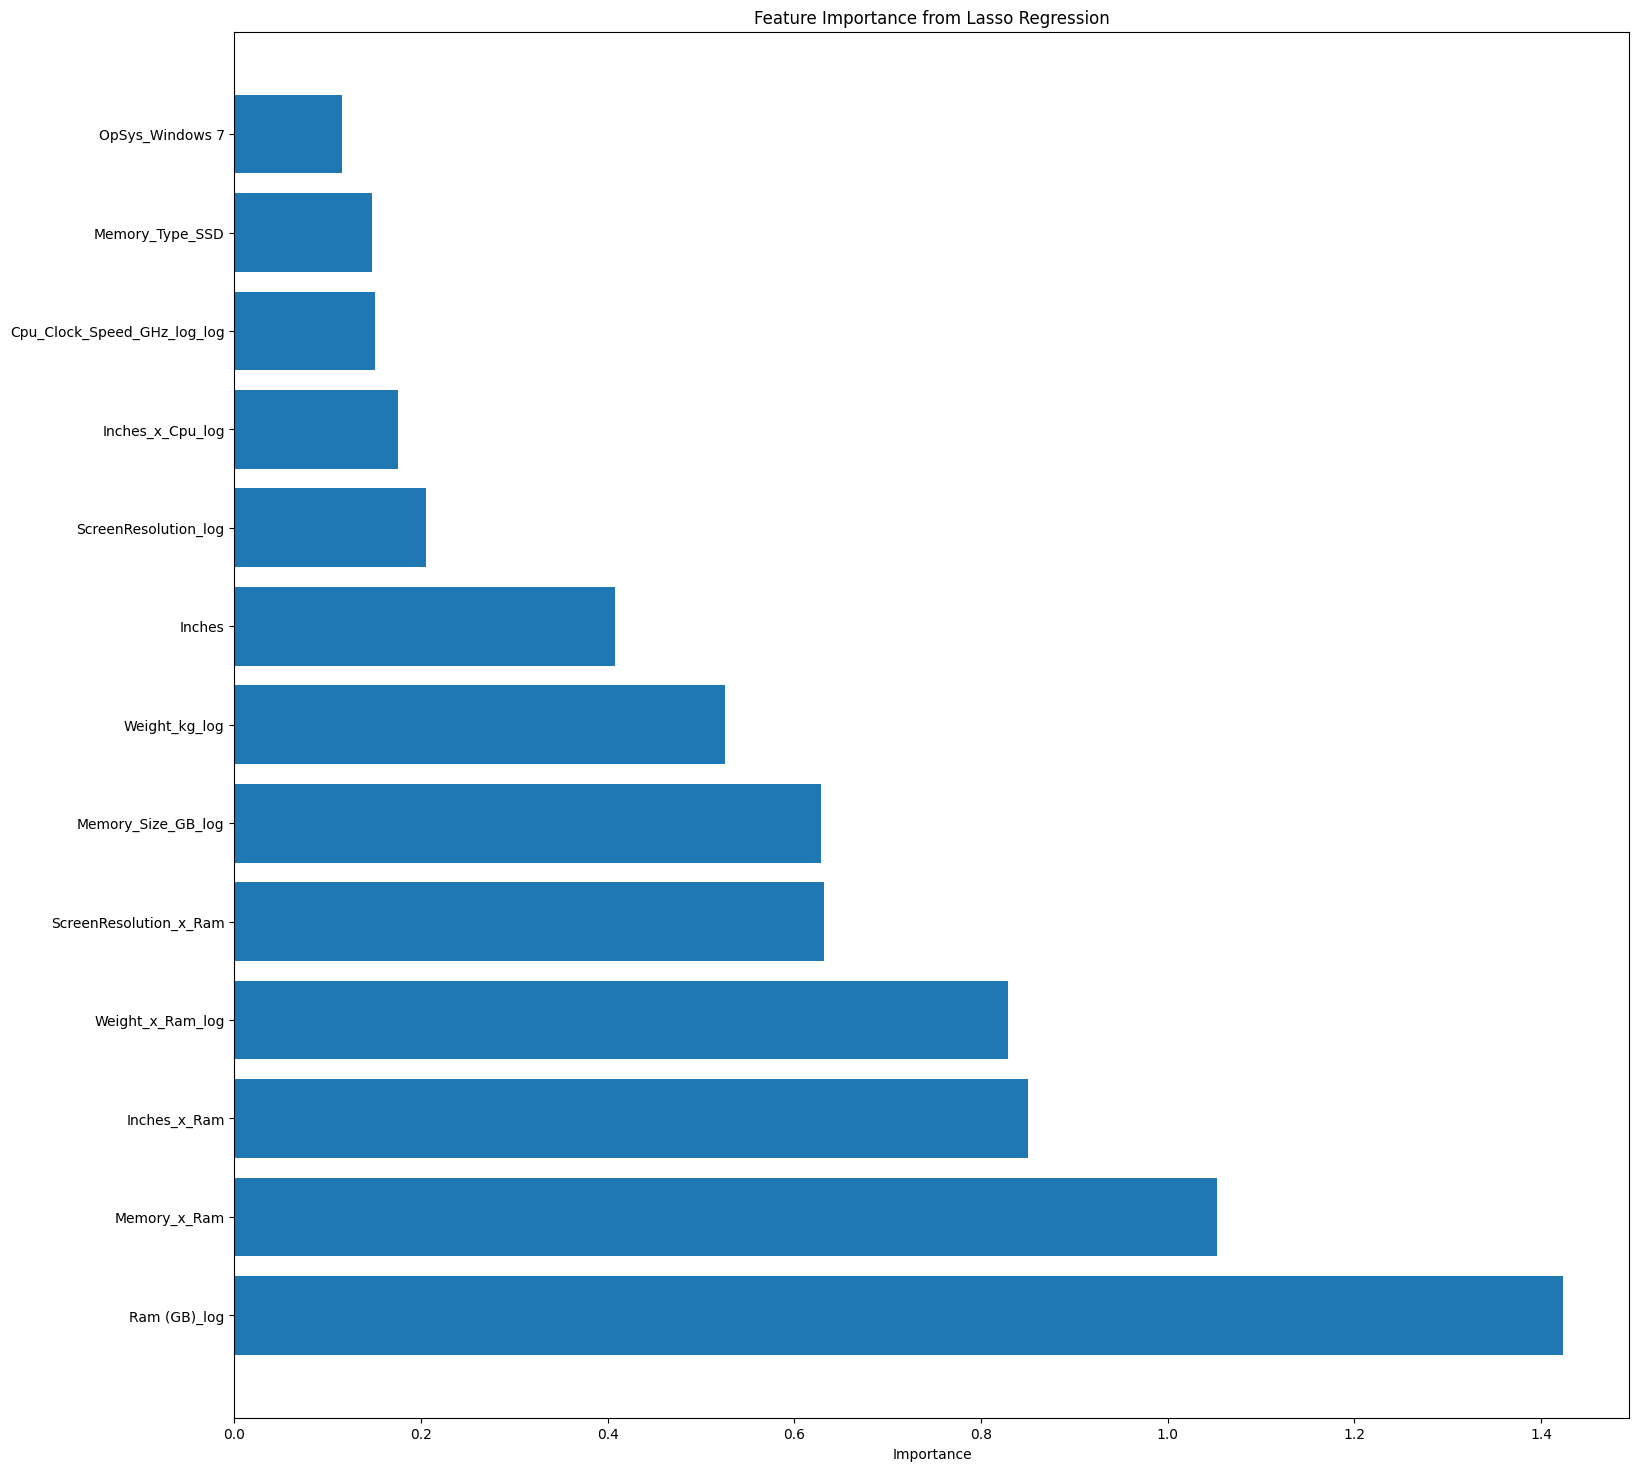

In [8]:
def regression_comparison(df, threshold=0.1):
    # Separate features and target
    if 'Price_log' in df.columns:
        X = df.drop(columns=['Price_log'])
        y = df['Price_log']
    else:
        # If 'Price_log' is not available, fall back to 'Price'
        X = df.drop(columns=['Price'])
        y = df['Price']

    # Scaling features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Vanilla Linear Regression
    lr = LinearRegression()

    # Cross-validation
    lr_r2 = cross_val_score(lr, X_train, y_train, cv=5, scoring="r2").mean()

    print("Cross validated and optimized results:")
    print("Linear Regression R²:", lr_r2)
    
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'max_iter': [10000, 50000, 100000]  # Add max_iter to your grid
    }
    
    # Grid search for Ridge with R² scoring
    ridge_grid = GridSearchCV(Ridge(), param_grid=param_grid, cv=5, scoring="r2")
    ridge_grid.fit(X_train, y_train)
    best_ridge_r2 = ridge_grid.best_score_
    print("Best Ridge alpha:", ridge_grid.best_params_, " | R²:", best_ridge_r2)

    # Grid search for Lasso with R² scoring
    lasso_grid = GridSearchCV(Lasso(), param_grid=param_grid, cv=5, scoring="r2")
    lasso_grid.fit(X_train, y_train)
    best_lasso_r2 = lasso_grid.best_score_
    print("Best Lasso alpha:", lasso_grid.best_params_, " | R²:", best_lasso_r2)
        
    # Get Lasso coefficients (importance of each feature) from the best Lasso model
    lasso_coefficients = lasso_grid.best_estimator_.coef_

    # Create a dataframe to show the features and their corresponding coefficients
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Lasso Coefficient': lasso_coefficients
    })

    # Sort the feature importance by absolute coefficient values to see which are most impactful
    feature_importance['Abs Coefficient'] = feature_importance['Lasso Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs Coefficient', ascending=False)

    # Filter out features that are less important than the threshold
    important_features = feature_importance[feature_importance['Abs Coefficient'] > threshold]
    
    # Display the top features
    print("Filtered Feature Importances:")
    print(important_features)
    
    # Plot feature importance
    plt.figure(figsize=(18,18))
    plt.barh(important_features['Feature'], important_features['Abs Coefficient'])
    plt.xlabel('Importance')
    plt.title('Feature Importance from Lasso Regression')
    plt.show()

    # Get the list of important features
    important_feature_names = important_features['Feature'].tolist()
    
    # Create a new filtered dataframe using the selected features
    df_filtered = df[important_feature_names + [y.name]]
    
    
    return df_filtered, feature_importance


# Get the filtered dataframe and feature importances
df_filtered, feature_importance = regression_comparison(df_engineering, threshold = -10)

# Now you can pass the filtered dataframe through the function again
df_filtered_new, _ = regression_comparison(df_filtered)

df_filtered_final, _ = regression_comparison(df_filtered_new)



| Model (Cross-validated $R^2$)| Untransformed| Log-transformed | Feature engineered + originals | Feature engineered |
| :---------------------------: | :-----------: | :-------------: | :----------:| :----------: |
| Linear Regression            | 0.745        |   0.802         |   0.816  |   0.794      |           
| Ridge Regression             | not-tested   |   0.803         |   0.815  |   0.794      |   
| Lasso Regression             | not-tested   |   0.803         |   0.816  |   0.796      |   

### By Noah Knijff https://github.com/noahknijff